In [1]:
# !pip install -U scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install torch torchvision torchaudio


#Pytorch 

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import math


from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

In [2]:
def null_values_detect(df, view=False):
    # La estructura de la funcion es la siguiente:
    # 1. Encontrar los indices con valores nulos nan
    # 2. Encontrar los indices con valores nulos nan consecutivos
    # 3. Encontrar los indices con valores nulos nan consecutivos mayores a 5 dias
    # 4. Encontrar las fechas de inicio y fin para el entrenamiento y prediccion
    # *** En train se almacenan primero la fecha de inicio y despues la fecha de fin del entrenamiento*** 
    # *** En pred se almacenan primero la fecha de inicio y despues la fecha de fin de la prediccion***
    
    # Variable definida para mantener estatico el valor de la fecha de inicio 
    if pd.isnull(df.iloc[0][0]) == True:
        a = 1
        b = 2 # Variable para saber si empezar por el segundo grupo o por el primero al encontrar un valor nulo en la primera fila 
    else:
        a = 0
        b = 0

    aux = 0

    nan_index = df[df.isnull().any(axis=1)].index 
    nan_index = nan_index.to_numpy().reshape(-1, 1)

    index_null_consec = []
    for i in range(len(nan_index)):
        if i == 0:
            index_null_consec.append(nan_index[i])
        else:
            if nan_index[i] - nan_index[i-1] != pd.Timedelta('1 hour 00:00:00'):
                fecha = nan_index[i-1]
                index_null_consec.append(fecha)
                index_null_consec.append(nan_index[i])

    # listas para agregar las fechas de inicio y fin de entrenaminto y prediccion
    train_values = []
    pred_values = [] 
    for x in range(int(b),len(index_null_consec)-1,2):
        imputation_null = df.loc[index_null_consec[x][0]:index_null_consec[x+1][0]]
        if imputation_null.isnull().sum().values[0] < 120: #Analizar la posibilidad de que el grupo de train sea mas pequeño que el test 
            init_date_next = index_null_consec[x-1][0] + pd.Timedelta('1 hour 00:00:00')
            if a == 1:
                data_complete = init_date_next
                train_values.append(data_complete)
                a = 0
            end_date = index_null_consec[x][0] - pd.Timedelta('1 hour 00:00:00')
            train_values.append(end_date)
            if view == True:
                print('-'*100)
                print('Fechas de inicio y fin para el entrenamiento')
                print('Fecha de inicio --> {}, indice entrenamiento: {}'.format(data_complete, aux))
                print('Fecha de fin -----> {}, indice entrenamiento: {}'.format(end_date, aux+1) )
                print('Fechas de inicio y fin para la prediccion')
                print('Fecha de inicio --> {}, indice prediccion: {}'.format(index_null_consec[x][0], aux))
                print('Fecha de fin -----> {}, indice prediccion: {}'.format(index_null_consec[x+1][0], aux+1))
                print('Datos perdidos -->', imputation_null.isnull().sum().values[0])
            pred_values.append(index_null_consec[x][0])
            pred_values.append(index_null_consec[x+1][0])
            aux += 2

        else:
            if view == True:
                print('El valor del datos perdidos es mayor a 5 dias (> 120 datos), valores perdidos =', 
            imputation_null.isnull().sum().values[0])

    return train_values, pred_values

# Guardar la variable imputation_lluvia_aitsu en otra variable para las modificaciones
data_river_2 = pd.read_csv('db_18.csv')
data_river_2 = data_river_2.set_index('Fecha')
# asignar un formato de fecha a la columna fecha
data_river_2.index = pd.to_datetime(data_river_2.index, format='%Y-%m-%d %H:%M:%S')
imputation_lluvia_aitsu = data_river_2[['B1Z1_NIVEL_RIO_Aitzu']].copy()
values_aitsu, pred_values_aitsu = null_values_detect(imputation_lluvia_aitsu, view=True)

El valor del datos perdidos es mayor a 5 dias (> 120 datos), valores perdidos = 528
El valor del datos perdidos es mayor a 5 dias (> 120 datos), valores perdidos = 456
----------------------------------------------------------------------------------------------------
Fechas de inicio y fin para el entrenamiento
Fecha de inicio --> 1999-03-04 00:00:00, indice entrenamiento: 0
Fecha de fin -----> 1999-03-12 23:00:00, indice entrenamiento: 1
Fechas de inicio y fin para la prediccion
Fecha de inicio --> 1999-03-13T00:00:00.000000000, indice prediccion: 0
Fecha de fin -----> 1999-03-16T16:00:00.000000000, indice prediccion: 1
Datos perdidos --> 89
----------------------------------------------------------------------------------------------------
Fechas de inicio y fin para el entrenamiento
Fecha de inicio --> 1999-03-04 00:00:00, indice entrenamiento: 2
Fecha de fin -----> 1999-03-31 23:00:00, indice entrenamiento: 3
Fechas de inicio y fin para la prediccion
Fecha de inicio --> 1999-04-01

In [3]:
# !pip install tqdm
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
def fit(model, dataloader, epoch=100):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    
    all_train_preds = []  # Lista para guardar todas las predicciones de entrenamiento por época
    all_eval_preds = [] 

    bar = tqdm(range(1,epoch+1))
    for epoch in bar:
        model.train()
        train_preds_epoch = []
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device).float(), y.to(device).float()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_preds_epoch.append(y_hat.detach().cpu().numpy())
        model.eval()
        eval_loss = []
        eval_preds_epoch = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device).float(), y.to(device).float()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_preds_epoch.append(y_hat.cpu().numpy())

        all_train_preds.append(train_preds_epoch)
        all_eval_preds.append(eval_preds_epoch)

        bar.set_description(f"Train Loss: {np.mean(train_loss):0.4f} Eval Loss: {np.mean(eval_loss):0.5f}")  
    return all_train_preds, all_eval_preds 

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device).float()
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds
    

    
print(device)

cuda


Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-03-12 23:00:00
(152, 1) (64, 1) (89, 1)
X_train : (102, 50, 1) y_train : (102, 1)
X_val : (14, 50, 1) y_val : (14, 1)
X_test : (1, 50, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 89


Train Loss: 0.0013 Eval Loss: 0.00121: 100%|██████████| 100/100 [00:00<00:00, 170.81it/s]


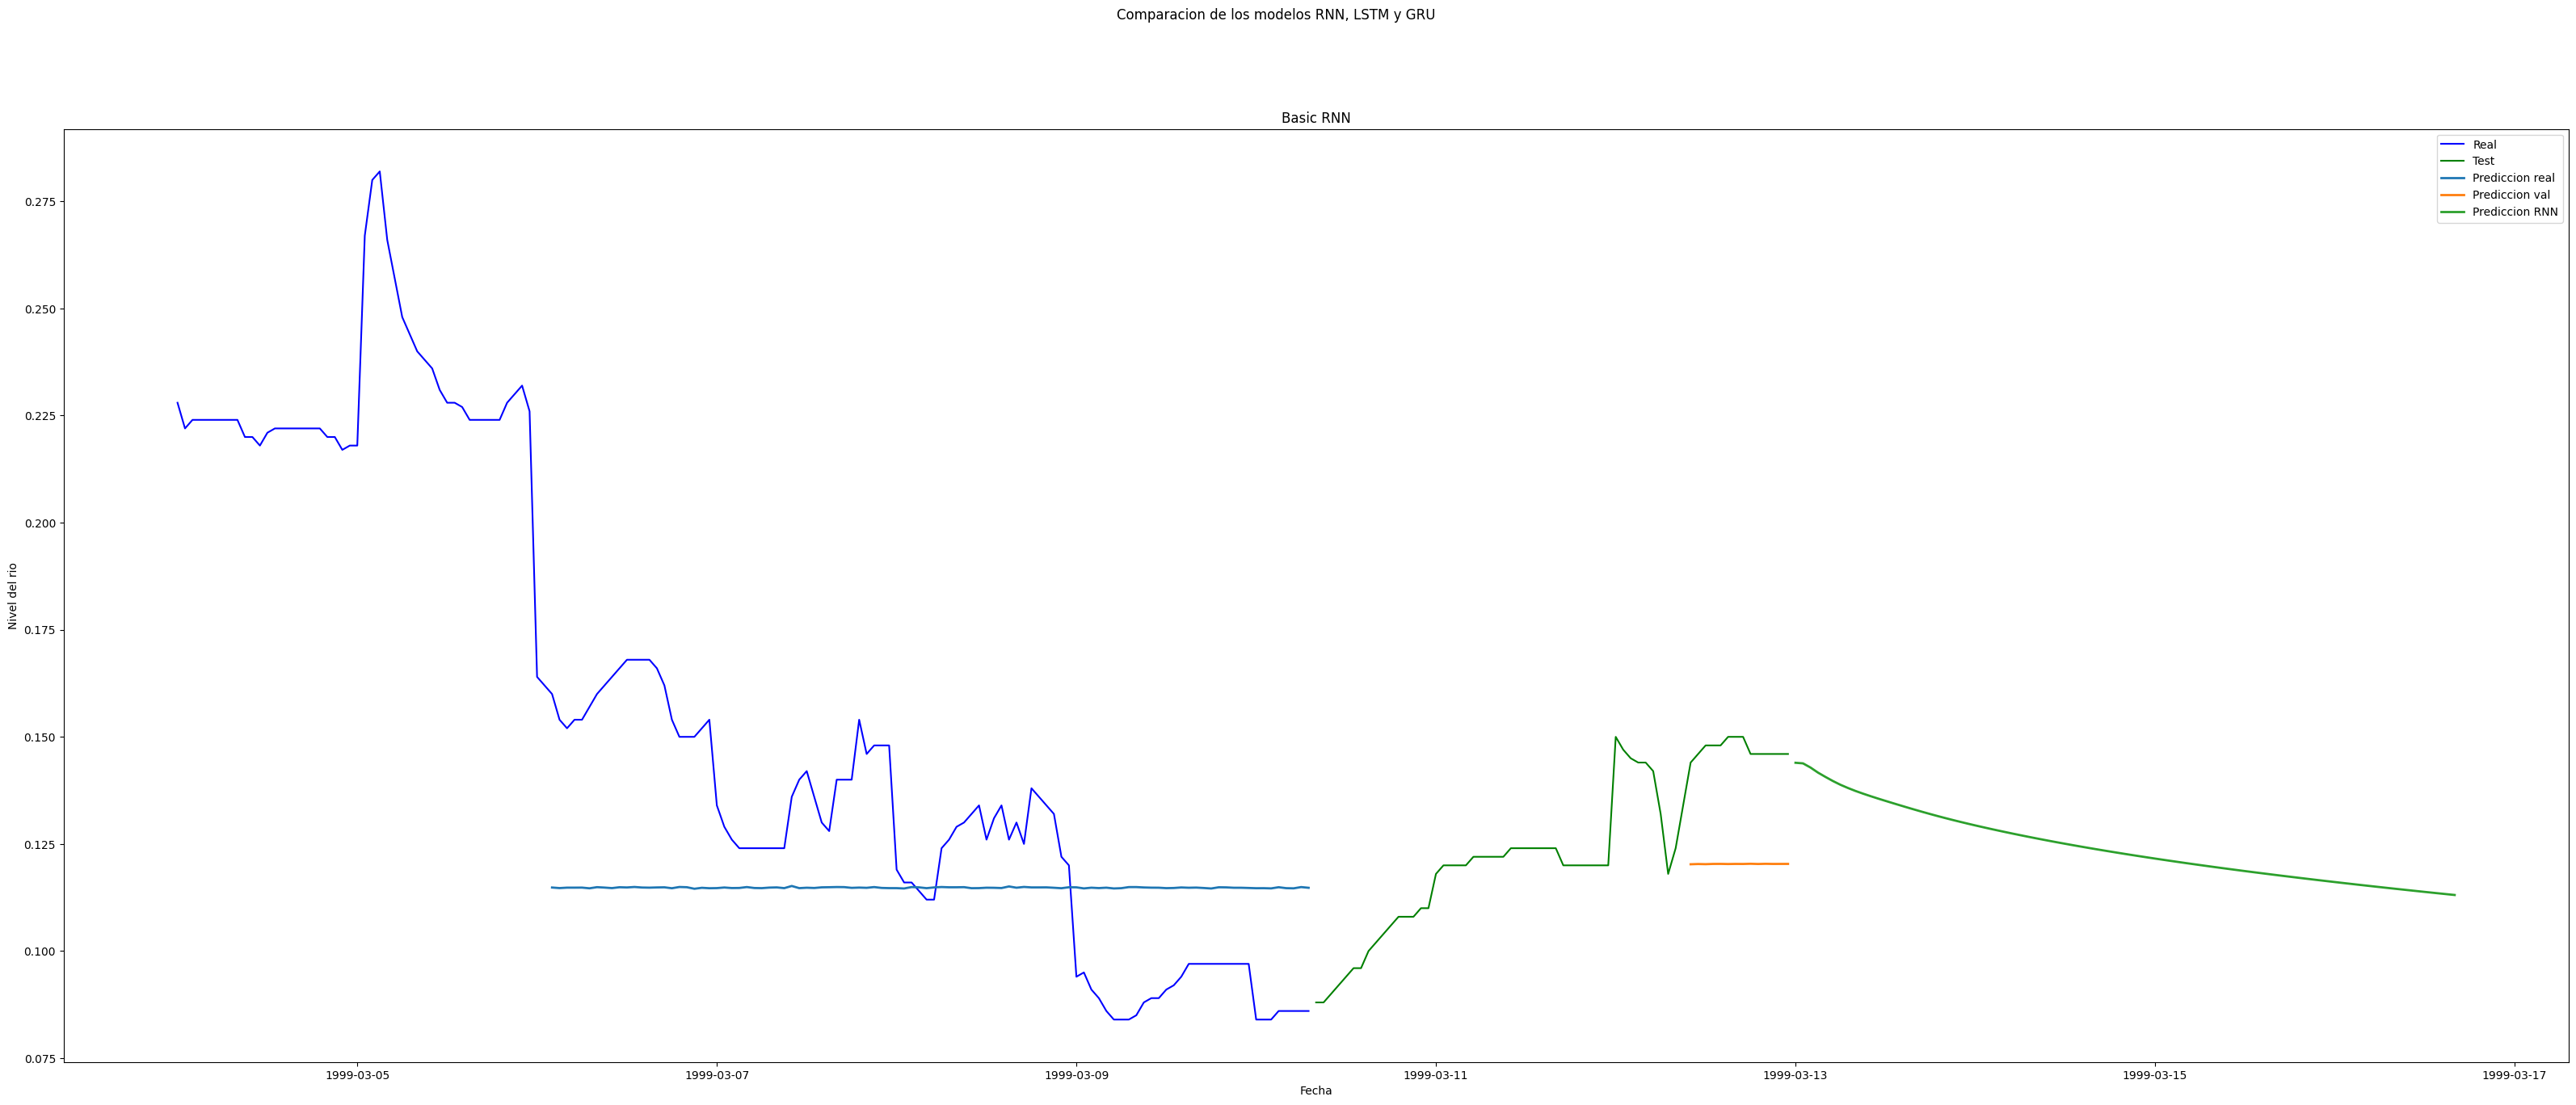

Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-03-31 23:00:00
(471, 1) (201, 1) (72, 1)
X_train : (399, 72, 1) y_train : (399, 1)
X_val : (129, 72, 1) y_val : (129, 1)
X_test : (1, 72, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 72


Train Loss: 0.0015 Eval Loss: 0.04091: 100%|██████████| 100/100 [00:01<00:00, 89.99it/s]


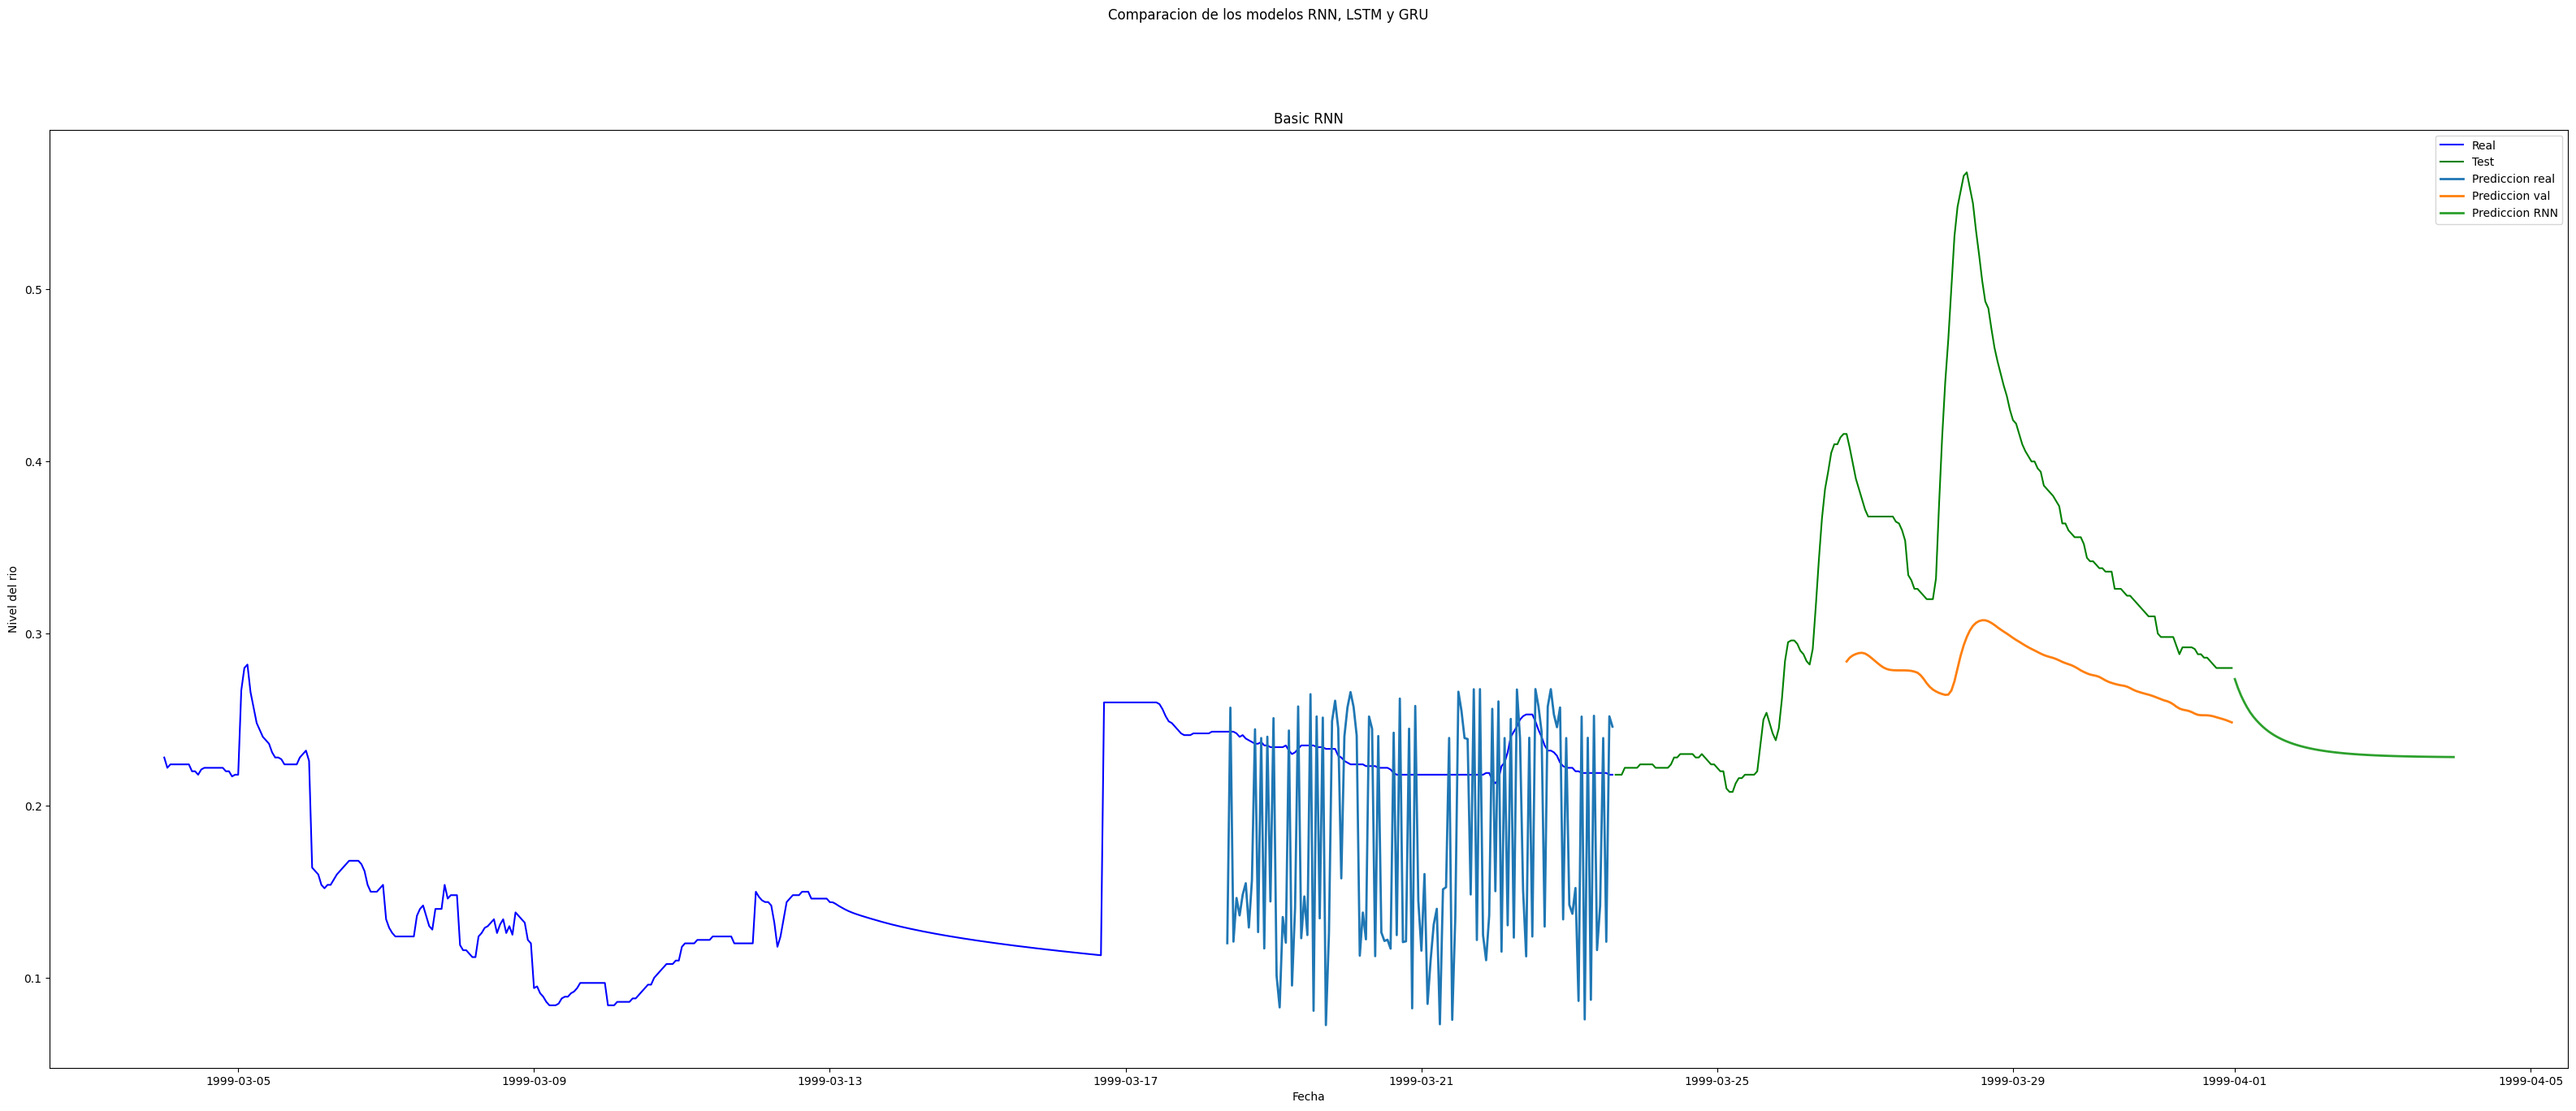

Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-04-30 23:00:00
(975, 1) (417, 1) (72, 1)
X_train : (903, 72, 1) y_train : (903, 1)
X_val : (345, 72, 1) y_val : (345, 1)
X_test : (1, 72, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 72


Train Loss: 0.0005 Eval Loss: 0.00023: 100%|██████████| 100/100 [00:02<00:00, 45.20it/s]


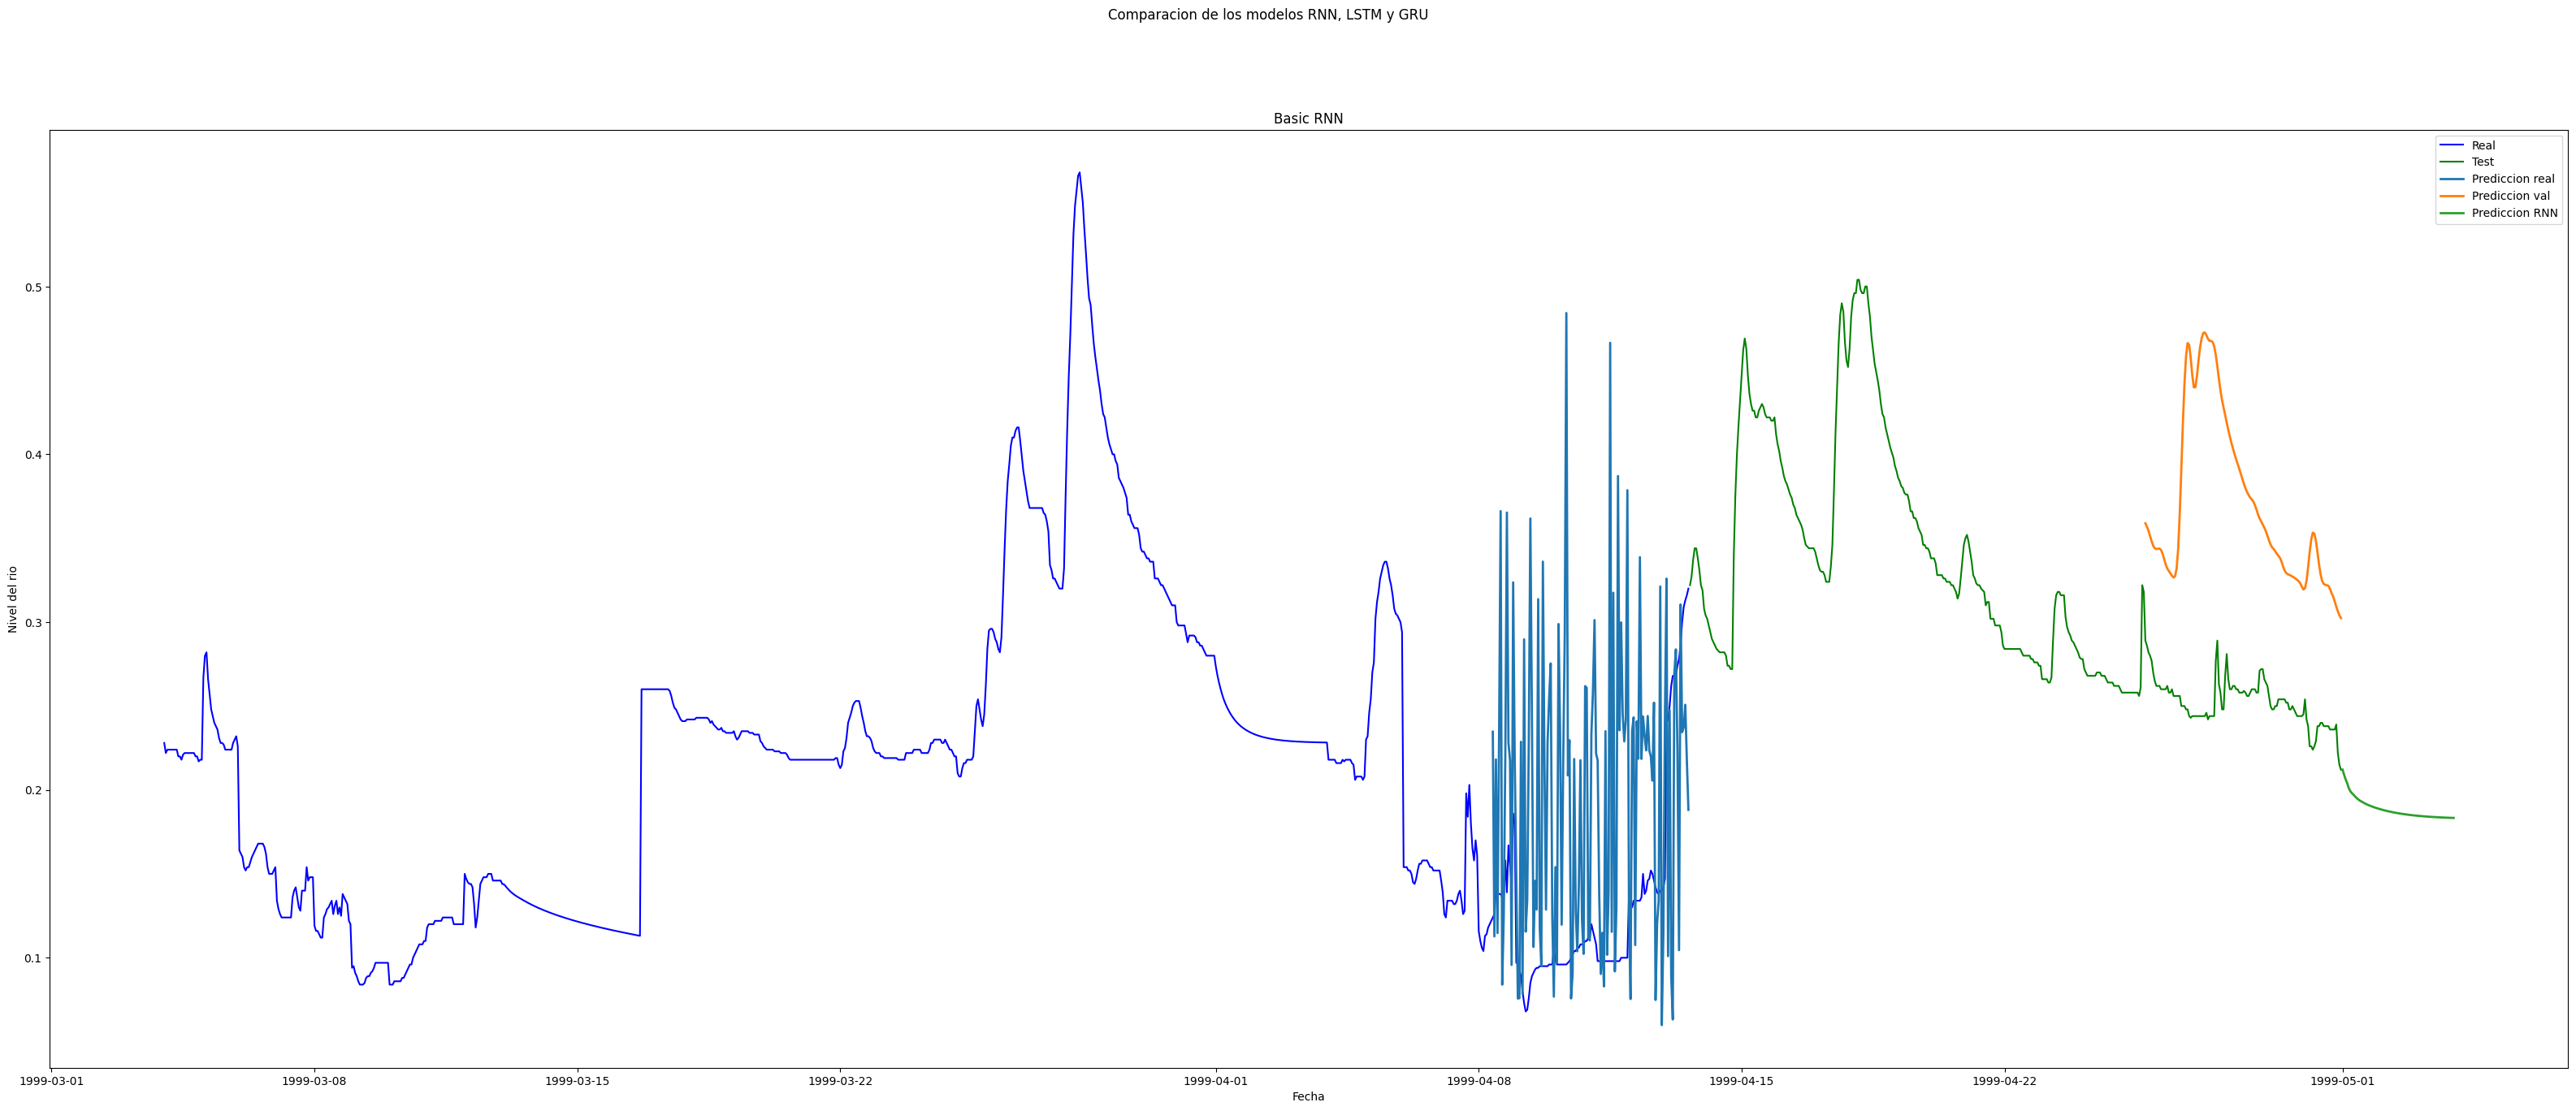

Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-05-31 23:00:00
(1496, 1) (640, 1) (72, 1)
X_train : (1424, 72, 1) y_train : (1424, 1)
X_val : (568, 72, 1) y_val : (568, 1)
X_test : (1, 72, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 72


Train Loss: 0.0004 Eval Loss: 0.00089: 100%|██████████| 100/100 [00:03<00:00, 31.72it/s]


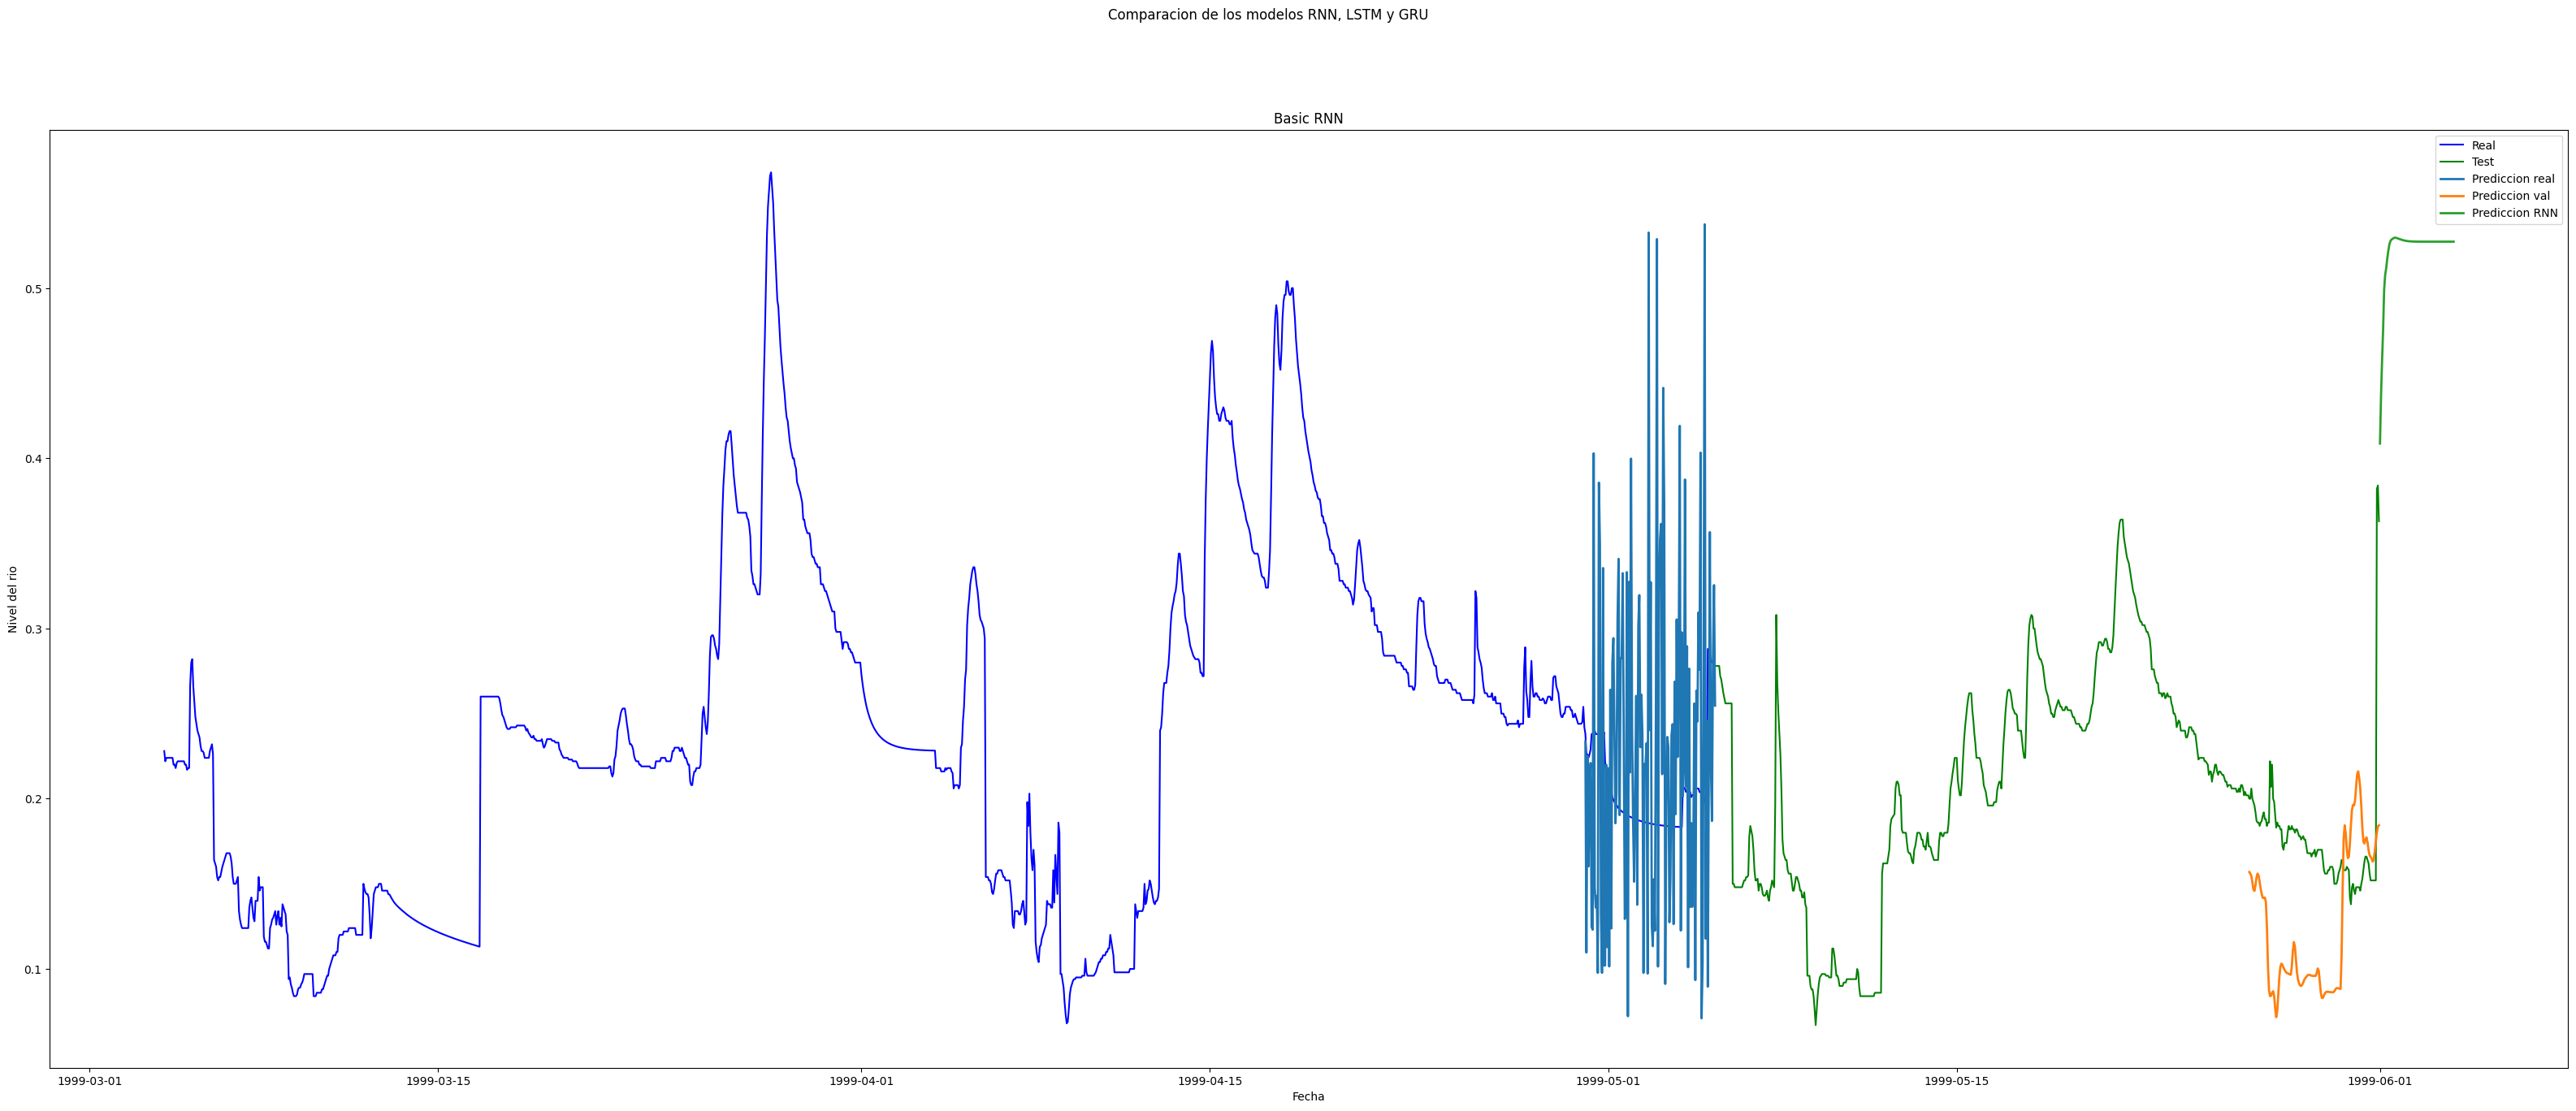

Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-06-30 23:00:00
(2000, 1) (856, 1) (72, 1)
X_train : (1928, 72, 1) y_train : (1928, 1)
X_val : (784, 72, 1) y_val : (784, 1)
X_test : (1, 72, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 72


Train Loss: 0.0005 Eval Loss: 0.00121: 100%|██████████| 100/100 [00:04<00:00, 24.19it/s]


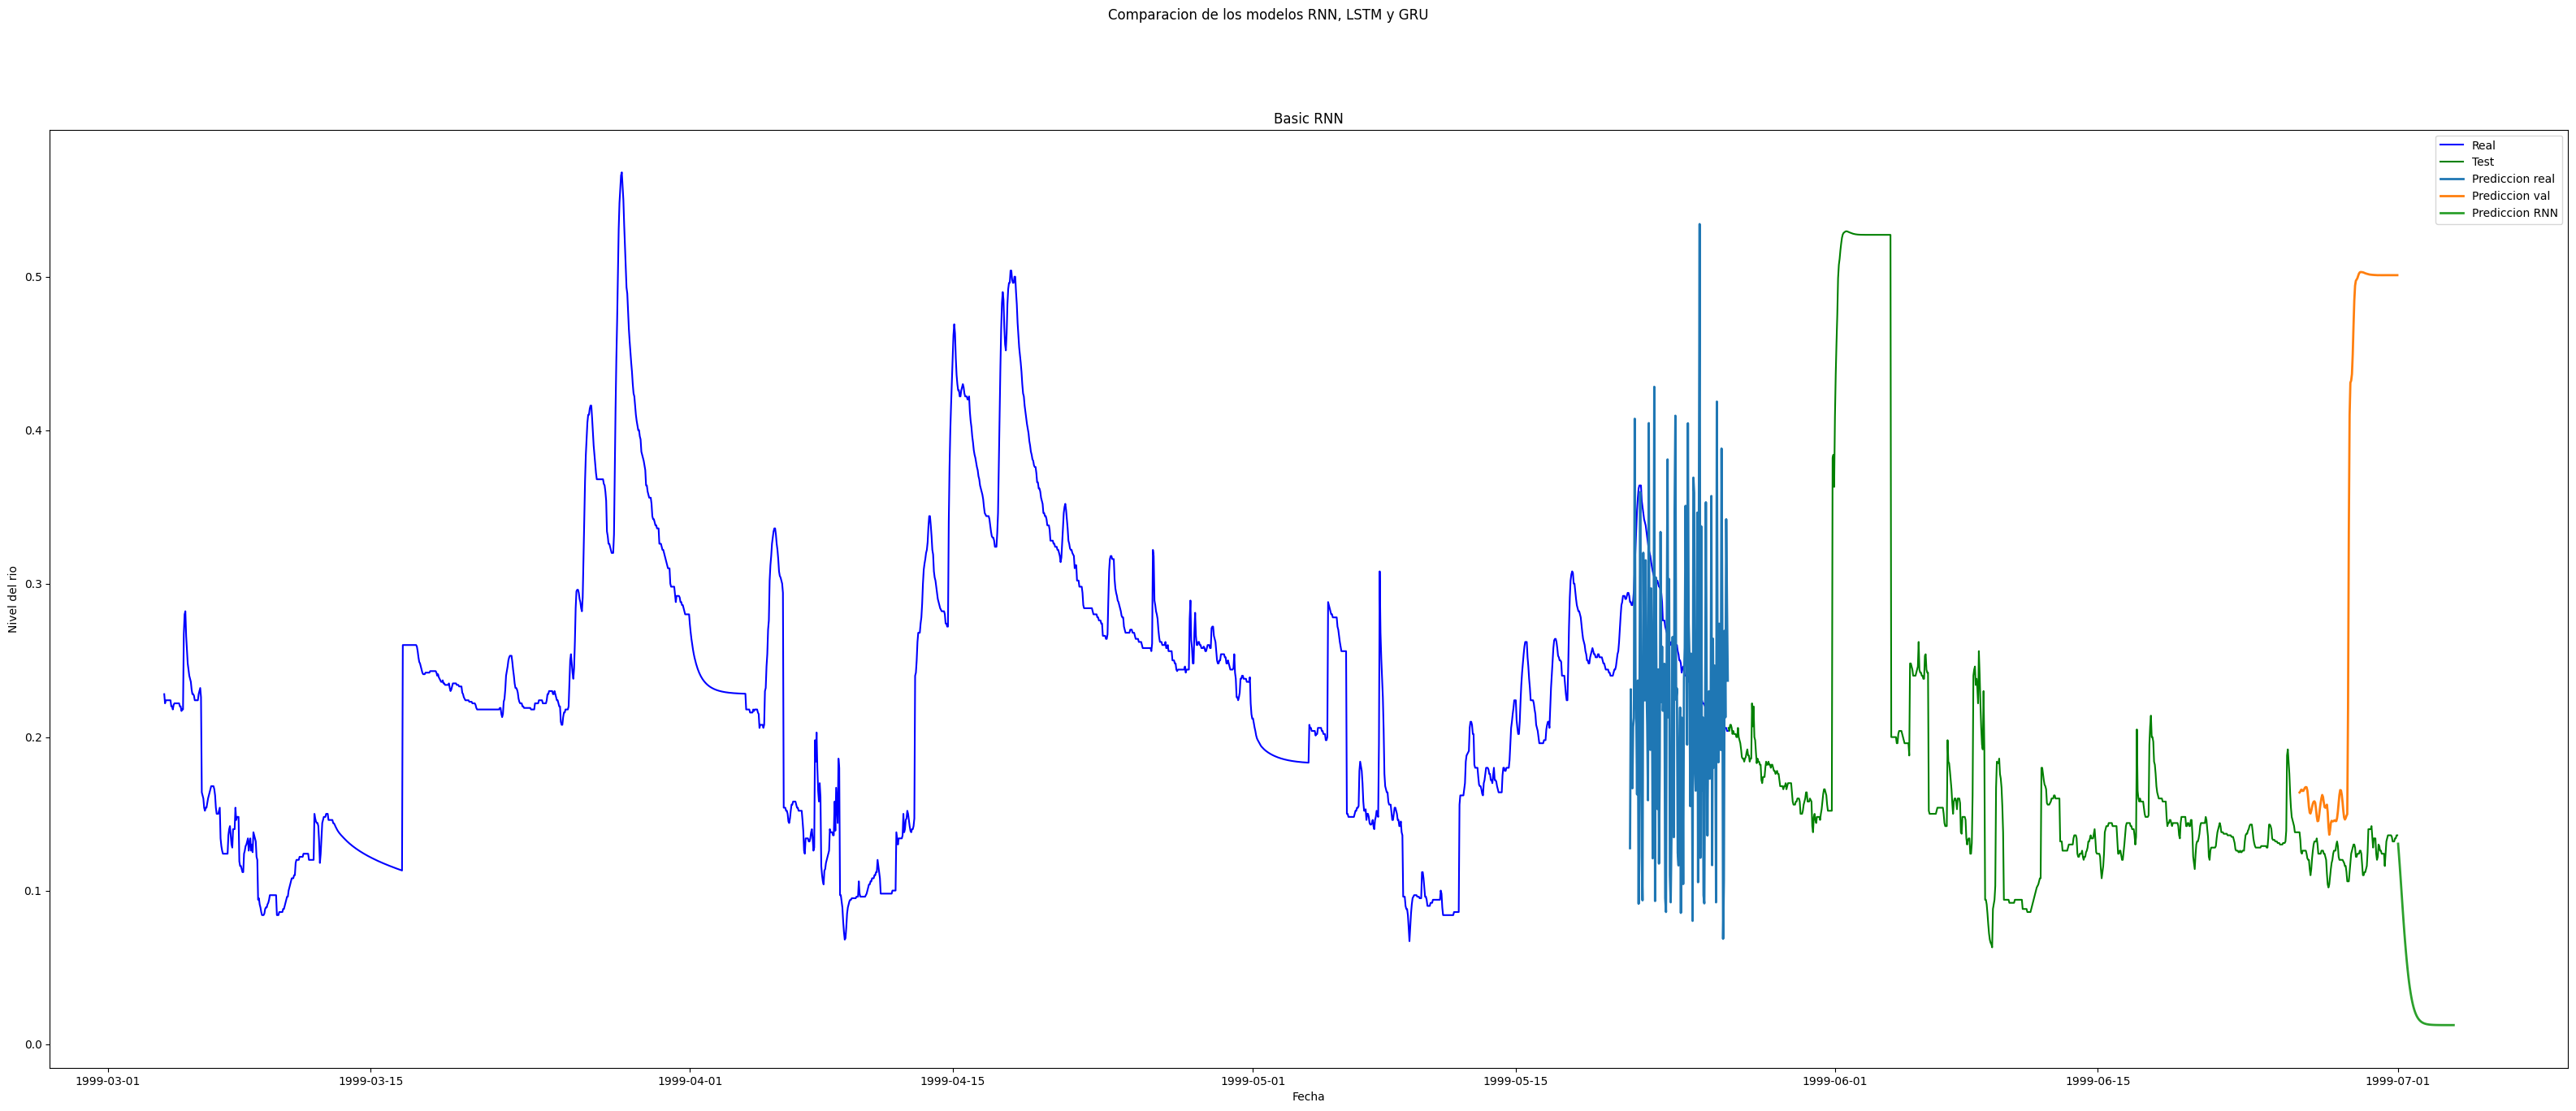

Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-07-31 23:00:00
(2520, 1) (1080, 1) (72, 1)
X_train : (2448, 72, 1) y_train : (2448, 1)
X_val : (1008, 72, 1) y_val : (1008, 1)
X_test : (1, 72, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 72


Train Loss: 0.0007 Eval Loss: 0.00047:  22%|██▏       | 22/100 [00:01<00:04, 18.53it/s]


KeyboardInterrupt: 

In [4]:
# Usando Pytorch
aux = 0
for x in range(50):
    data = imputation_lluvia_aitsu[values_aitsu[0]:values_aitsu[x+1]]
    print('Fecha de inicio ----> ', data.index[0])
    print('Fecha de fin ------> ', data.index[-1])
    data = data.asfreq('H')
    training_data_len = math.ceil(len(data)* 0.7)

    dataset_train = data[:training_data_len].iloc[:,:1]  
    dataset_val = data[training_data_len:].iloc[:,:1]
    dataset_test = imputation_lluvia_aitsu[pred_values_aitsu[aux]:pred_values_aitsu[aux+1]]
    aux += 2
    # #Cambiar los valores nan por valores 0
    # dataset_dataset_test = dataset_test.fillna(0) 
    print(dataset_train.shape, dataset_val.shape, dataset_test.shape)


    num_values_miss = dataset_test.isnull().sum().values[0]

    if num_values_miss > 50 and len(dataset_train) < 200:
        num_values_miss = 50
    else:
        num_values_miss = num_values_miss

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler_train = scaler.fit_transform(dataset_train)
    scaled_val = scaler.transform(dataset_val)

    X_train = []
    y_train = []

    for i in range(num_values_miss, len(scaler_train)):
        X_train.append(scaler_train[i-num_values_miss:i, 0])
        y_train.append(scaler_train[i, 0])

    X_val = []
    y_val = []

    for i in range(num_values_miss, len(scaled_val)):
        X_val.append(scaled_val[i-num_values_miss:i, 0])
        y_val.append(scaled_val[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    print('X_train :', X_train.shape, 'y_train :', y_train.shape)

    X_val, y_val = np.array(X_val), np.array(y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    y_val = np.reshape(y_val, (y_val.shape[0], 1))
    print('X_val :', X_val.shape, 'y_val :', y_val.shape)

    X_test = X_val[X_val.shape[0]-1:X_val.shape[0]]

    print('X_test :', X_test.shape)

    print('Valores perdidos en los data sets: Train: {}, Val: {}, Test: {}'.format(dataset_train.isnull().sum().values[0], dataset_val.isnull().sum().values[0], dataset_test.isnull().sum().values[0]))

    class TimeSeriesDataset(Dataset):
        def __init__(self, X, y=None, train=None):
            self.X = X
            self.y = y
            self.train = train

        def __len__(self):
            return len(self.X)

        def __getitem__(self, ix):
            if self.train:
                return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
            return torch.from_numpy(self.X[ix])
        
    dataset ={
        'train' : TimeSeriesDataset(X_train, y_train, train=True),
        'eval' : TimeSeriesDataset(X_val, y_val, train=True),
        'test' : TimeSeriesDataset(X_test, train=False)
    } 

    dataloader = {
        'train' : DataLoader(dataset['train'], batch_size=126, shuffle=True),
        'eval' : DataLoader(dataset['eval'], batch_size=126, shuffle=False),
        'test' : DataLoader(dataset['test'], batch_size=126, shuffle=False)
    }

    class RNN(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.rnn = torch.nn.RNN(input_size=1, hidden_size=80, num_layers=5, batch_first=True)
            self.fc = torch.nn.Linear(80, 1)

        def forward(self, x):
            x, h = self.rnn(x)
            y = self.fc(x[:,-1])
            return y

    rnn = RNN()

    train_points, eval_points =fit(rnn, dataloader)

    y_pred = predict(rnn, dataloader['test'])
    y_pred

    X = X_test

    for step_ahead in range(dataset_test.isnull().sum().values[0]):
        inputs = torch.from_numpy(X[:,:,:]).unsqueeze(0)
        # print(inputs.shape)
        # print(inputs)
        y_pred_one = predict(rnn, inputs).cpu().numpy()
        X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

    y_pred = X[:, -dataset_test.isnull().sum().values[0]:, -1]
    y_RNN_O_test = scaler.inverse_transform(y_pred) 
    y_RNN_O_test = y_RNN_O_test.reshape(-1,1)

    #Obtener el primer indice de dataset_test
    date = dataset_test[0:y_pred.shape[1]].index
    date = date.to_numpy().reshape(-1, 1)
    # print(date)
    fig, ax = plt.subplots(1,figsize=(40, 15), sharex=True, sharey=True)
    fig.suptitle('Comparacion de los modelos RNN, LSTM y GRU')

    ax.plot(dataset_train.index, dataset_train, label = 'Real', color = 'blue')
    ax.plot(dataset_val.index, dataset_val, color = 'g', label = 'Test')
    ax.plot(dataset_train.index[-(train_points[0][0].shape[0]):] , scaler.inverse_transform(train_points[9][0]), label = 'Prediccion real', linewidth=2)  
    ax.plot(dataset_val.index[-(eval_points[0][0].shape[0]):] , scaler.inverse_transform(eval_points[9][0]), label = 'Prediccion val', linewidth=2)  
    ax.plot(date , y_RNN_O_test, label = 'Prediccion RNN', linewidth=2)  
    ax.legend()
    ax.set_title('Basic RNN')  

    plt.xlabel('Fecha')
    plt.ylabel('Nivel del rio')

    plt.show() 

    y_RNN_O_test = pd.DataFrame(y_RNN_O_test, index=date.flatten(), columns=['B1Z1_NIVEL_RIO_Aitzu'])
    y_RNN_O_test
    imputation_lluvia_aitsu.update(y_RNN_O_test)

cuda


In [68]:
class DeepRNN(torch.nn.Module):
    def __init__(self, n_out=1):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(20, n_out)

    def forward(self, x):
        x, h = self.rnn(x)
        x_reshaped = x.contiguous().view(-1, x.shape[-1])
        y = self.fc(x_reshaped)
        y = y.contiguous().view(x.shape[0], -1, y.shape[-1])
        return y
    
class LSTM(DeepRNN):
    def __init__(self, n_out=10, dropout=0):
        super().__init__()
        self.rnn = torch.nn.LSTM(input_size=1, hidden_size=20, num_layers=2, batch_first=True, dropout=dropout)

rnn1 = DeepRNN() 
lstm = LSTM()

Train Loss: 0.0009 Eval Loss: 0.00050: 100%|██████████| 10/10 [00:00<00:00, 14.29it/s]


In [73]:
# train_points[0][0].shape    
eval_points[0][0].shape

(64, 1)

ValueError: x and y must have same first dimension, but have shapes (72, 1) and (116, 1)

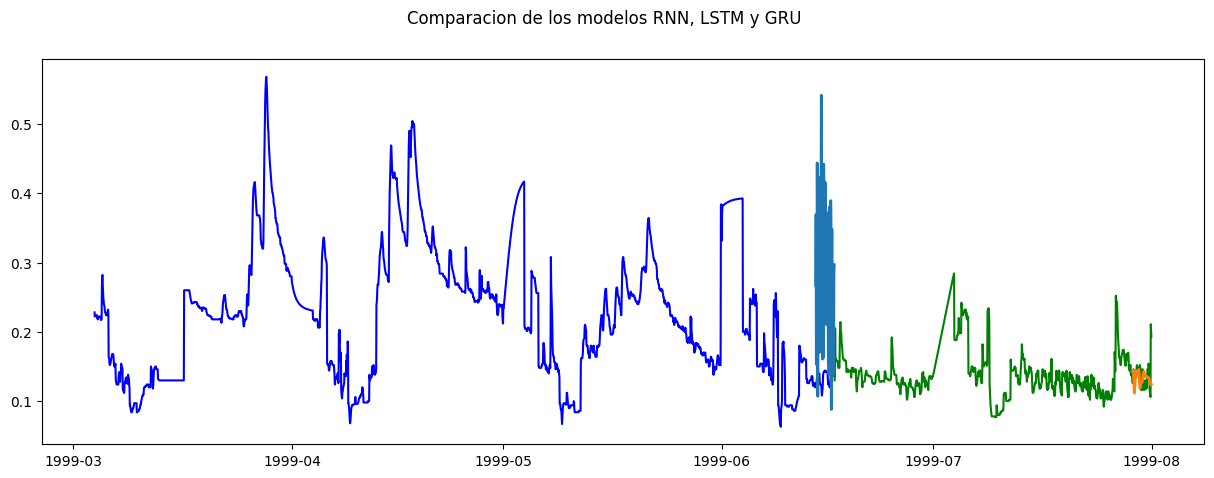

ValueError: Shape of passed values is (116, 1), indices imply (72, 1)

In [10]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epoch=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1,epoch+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device).float(), y.to(device).float()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device).float(), y.to(device).float()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"Train Loss: {np.mean(train_loss):0.4f} Eval Loss: {np.mean(eval_loss):0.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device).float()
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=None):
        self.X = X
        self.y = y
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        if self.train:
            return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
        return torch.from_numpy(self.X[ix])

In [12]:
class DeepRNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(20,1)

    def forward(self, x):
        x, h = self.rnn(x)
        x_reshape = x.contiguous().view(-1, x.size(-1))
        y = self.fc(x_reshape)
        y = y.contiguous().view(x.size(0), x.size(1), -1)
        return y

class LSTM(DeepRNN):
    def __init__(self, n_out = 1, dropout=0):
        super().__init__()
        self.rnn = torch.nn.LSTM(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)
        

class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(20,1)

    def forward(self, x):
        x, _ = self.rnn(x)
        y = self.fc(x[:,-1])
        return y

Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-03-12 23:00:00
89
(152, 1) (64, 1) (89, 1)
89
X_train : (102, 50, 1) y_train : (102, 1)
X_val : (14, 50, 1) y_val : (14, 1)
X_test : (1, 50, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 89


  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0164 Eval Loss: 0.01167: 100%|██████████| 10/10 [00:00<00:00, 33.88it/s]


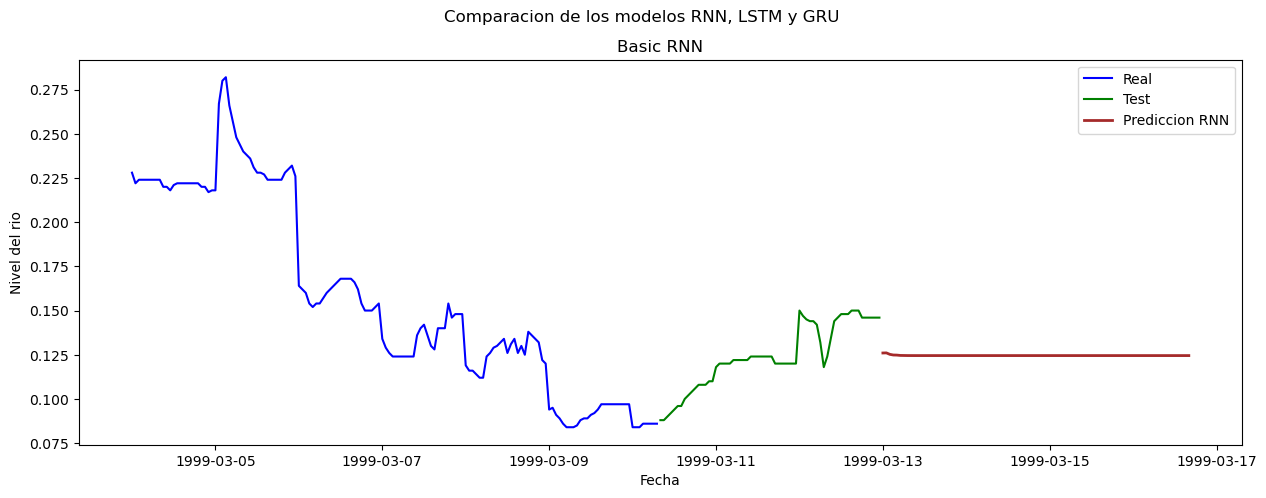

1999-03-13 00:00:00 1999-03-16 16:00:00
Fecha de inicio ---->  1999-03-04 00:00:00
Fecha de fin ------>  1999-03-31 23:00:00
369
(471, 1) (201, 1) (369, 1)
369
X_train : (421, 50, 1) y_train : (421, 1)
X_val : (151, 50, 1) y_val : (151, 1)
X_test : (1, 50, 1)
Valores perdidos en los data sets: Train: 0, Val: 0, Test: 1


Train Loss: 0.0049 Eval Loss: 0.12776: 100%|██████████| 10/10 [00:00<00:00, 39.41it/s]


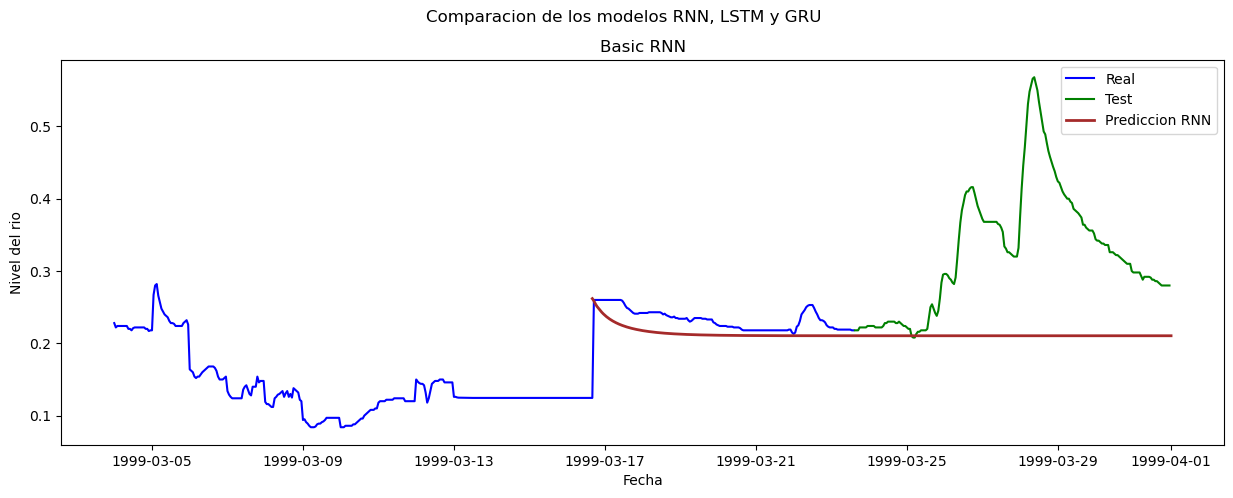

1999-03-16 16:00:00 1999-04-01 00:00:00


In [13]:
# Usando Pytorch
for x in range(2):
    data = imputation_lluvia_aitsu[values_aitsu[0]:values_aitsu[x+1]]
    print('Fecha de inicio ----> ', data.index[0])
    print('Fecha de fin ------> ', data.index[-1])
    data = data.asfreq('H')
    training_data_len = math.ceil(len(data)* 0.7)

    dataset_train = data[:training_data_len].iloc[:,:1]  
    dataset_val = data[training_data_len:].iloc[:,:1]
    dataset_test = imputation_lluvia_aitsu[pred_values_aitsu[x]:pred_values_aitsu[x+1]]
    print(dataset_test.shape[0])
    #Cambiar los valores nan por valores 0
    print(dataset_train.shape, dataset_val.shape, dataset_test.shape)

    num_values_miss = dataset_test.shape[0] 
    print(num_values_miss)

    if num_values_miss > 50:
        num_values_miss = 50
    else:
        num_values_miss = num_values_miss

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler_train = scaler.fit_transform(dataset_train)
    scaled_val = scaler.transform(dataset_val)

    X_train = []
    y_train = []


    for i in range(num_values_miss, len(scaler_train)):
        X_train.append(scaler_train[i-num_values_miss:i, 0])
        y_train.append(scaler_train[i, 0])

    X_val = []
    y_val = []
    for i in range(num_values_miss, len(scaled_val)):
        X_val.append(scaled_val[i-num_values_miss:i, 0])
        y_val.append(scaled_val[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    print('X_train :', X_train.shape, 'y_train :', y_train.shape)

    X_val, y_val = np.array(X_val), np.array(y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    y_val = np.reshape(y_val, (y_val.shape[0], 1))
    print('X_val :', X_val.shape, 'y_val :', y_val.shape)

    X_test = X_val[X_val.shape[0]-1:X_val.shape[0]]

    print('X_test :', X_test.shape)

    print('Valores perdidos en los data sets: Train: {}, Val: {}, Test: {}'.format(dataset_train.isnull().sum().values[0], dataset_val.isnull().sum().values[0], dataset_test.isnull().sum().values[0]))

    dataset ={
        'train' : TimeSeriesDataset(X_train, y_train, train=True),
        'eval' : TimeSeriesDataset(X_val, y_val, train=True),
        'test' : TimeSeriesDataset(X_test, train=False)
    } 

    dataloader = {
        'train' : DataLoader(dataset['train'], batch_size=64, shuffle=True),
        'eval' : DataLoader(dataset['eval'], batch_size=64, shuffle=False),
        'test' : DataLoader(dataset['test'], batch_size=64, shuffle=False)
    }

    rnn1 = RNN() 

    fit(rnn1, dataloader)
    # resetear la variable y_pred  
  
    n_steps = num_values_miss
    # y_pred = predict(rnn1, dataloader['test'])
    # y_pred

    X = X_test
    for step_ahead in range(dataset_test.shape[0]):
        inputs = torch.from_numpy(X[:,step_ahead:]).unsqueeze(0)
        y_pred_one = predict(rnn1, inputs).cpu().numpy()
        X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

    y_pred = X[:, n_steps:, -1]
    y_RNN_O_test = scaler.inverse_transform(y_pred) 
    # y_RNN_O_test = y_RNN_O_test.reshape(-1,1)

    

    #Obtener el primer indice de dataset_test
    fig, ax = plt.subplots(1,figsize=(15, 5), sharex=True, sharey=True)
    fig.suptitle('Comparacion de los modelos RNN, LSTM y GRU')

    ax.plot(dataset_train.index, dataset_train, label = 'Real', color = 'blue')
    ax.plot(dataset_val.index, dataset_val, color = 'g', label = 'Test')
    ax.plot(dataset_test.index , y_RNN_O_test.T, color = 'brown', label = 'Prediccion RNN', linewidth=2)  
    ax.legend()
    ax.set_title('Basic RNN')  

    plt.xlabel('Fecha')
    plt.ylabel('Nivel del rio')

    plt.show() 

    fecha_inicio =  (dataset_test.index[0])
    fecha_fin = (dataset_test.index[-1])
    print(fecha_inicio, fecha_fin)
    fecha = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='H')
    df_fechas = pd.DataFrame(fecha, columns=['Fecha'])
    pred_LSTM_test = pd.concat([df_fechas, pd.DataFrame(y_RNN_O_test.T, columns=['B1Z1_NIVEL_RIO_Aitzu'])], axis=1)
    pred_LSTM_test = pred_LSTM_test.set_index('Fecha')
    pred_LSTM_test

    imputation_lluvia_aitsu.update(pred_LSTM_test)

Train Loss: 0.0240 Eval Loss: 0.31507: 100%|██████████| 10/10 [00:00<00:00, 37.11it/s]


[['1999-03-16T16:00:00.000000000']
 ['1999-03-16T17:00:00.000000000']
 ['1999-03-16T18:00:00.000000000']
 ['1999-03-16T19:00:00.000000000']
 ['1999-03-16T20:00:00.000000000']
 ['1999-03-16T21:00:00.000000000']
 ['1999-03-16T22:00:00.000000000']
 ['1999-03-16T23:00:00.000000000']
 ['1999-03-17T00:00:00.000000000']
 ['1999-03-17T01:00:00.000000000']
 ['1999-03-17T02:00:00.000000000']
 ['1999-03-17T03:00:00.000000000']
 ['1999-03-17T04:00:00.000000000']
 ['1999-03-17T05:00:00.000000000']
 ['1999-03-17T06:00:00.000000000']
 ['1999-03-17T07:00:00.000000000']
 ['1999-03-17T08:00:00.000000000']
 ['1999-03-17T09:00:00.000000000']
 ['1999-03-17T10:00:00.000000000']
 ['1999-03-17T11:00:00.000000000']
 ['1999-03-17T12:00:00.000000000']
 ['1999-03-17T13:00:00.000000000']
 ['1999-03-17T14:00:00.000000000']
 ['1999-03-17T15:00:00.000000000']
 ['1999-03-17T16:00:00.000000000']
 ['1999-03-17T17:00:00.000000000']
 ['1999-03-17T18:00:00.000000000']
 ['1999-03-17T19:00:00.000000000']
 ['1999-03-17T20:00:

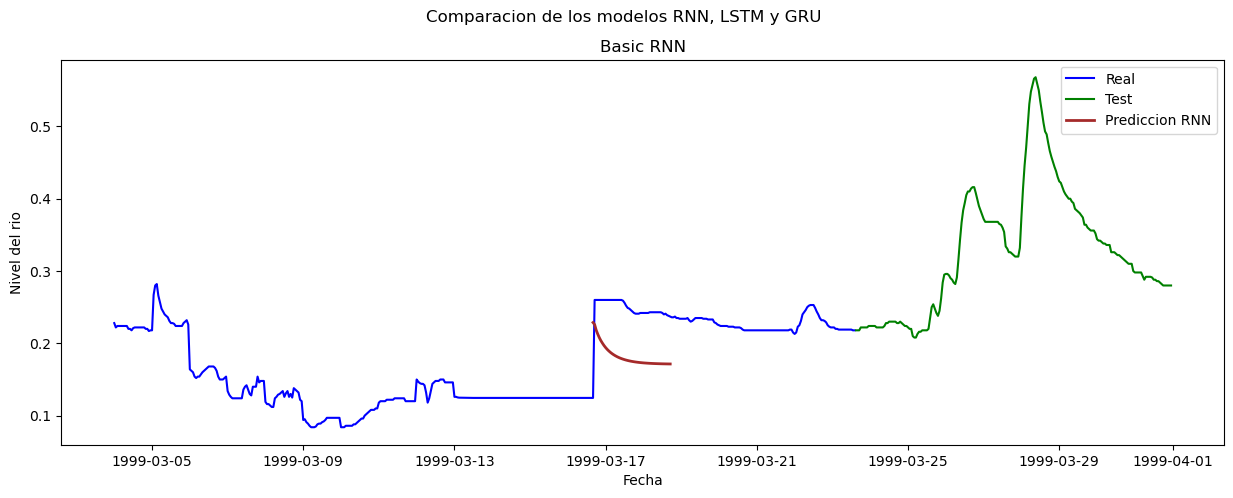

In [14]:
class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
        self.fc = torch.nn.Linear(20,1)

    def forward(self, x):
        x, _ = self.rnn(x)
        y = self.fc(x[:,-1])
        return y

rnn1 = RNN() 

fit(rnn1, dataloader)

n_steps = 50
y_pred = predict(rnn1, dataloader['test'])
y_pred

X = X_test
for step_ahead in range(50):
    inputs = torch.from_numpy(X[:,step_ahead:]).unsqueeze(0)
    
    y_pred_one = predict(rnn1, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
y_RNN_O_test = scaler.inverse_transform(y_pred) 
y_RNN_O_test = y_RNN_O_test.reshape(-1,1)



#Obtener el primer indice de dataset_test
date = dataset_test[0:y_pred.shape[1]].index
date = date.to_numpy().reshape(-1, 1)
print(date)
fig, ax = plt.subplots(1,figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle('Comparacion de los modelos RNN, LSTM y GRU')

ax.plot(dataset_train.index, dataset_train, label = 'Real', color = 'blue')
ax.plot(dataset_val.index, dataset_val, color = 'g', label = 'Test')
ax.plot(date , y_RNN_O_test, color = 'brown', label = 'Prediccion RNN', linewidth=2)  
ax.legend()
ax.set_title('Basic RNN')  

plt.xlabel('Fecha')
plt.ylabel('Nivel del rio')

plt.show() 

In [ ]:
====================================================

In [1]:
#Pytorch 

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import math


from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

def null_values_detect(df, view=False):
    # La estructura de la funcion es la siguiente:
    # 1. Encontrar los indices con valores nulos nan
    # 2. Encontrar los indices con valores nulos nan consecutivos
    # 3. Encontrar los indices con valores nulos nan consecutivos mayores a 5 dias
    # 4. Encontrar las fechas de inicio y fin para el entrenamiento y prediccion
    # *** En train se almacenan primero la fecha de inicio y despues la fecha de fin del entrenamiento*** 
    # *** En pred se almacenan primero la fecha de inicio y despues la fecha de fin de la prediccion***
    
    # Variable definida para mantener estatico el valor de la fecha de inicio 
    if pd.isnull(df.iloc[0][0]) == True:
        a = 1
        b = 2 # Variable para saber si empezar por el segundo grupo o por el primero al encontrar un valor nulo en la primera fila 
    else:
        a = 0
        b = 0

    aux = 0

    nan_index = df[df.isnull().any(axis=1)].index 
    nan_index = nan_index.to_numpy().reshape(-1, 1)

    index_null_consec = []
    for i in range(len(nan_index)):
        if i == 0:
            index_null_consec.append(nan_index[i])
        else:
            if nan_index[i] - nan_index[i-1] != pd.Timedelta('1 hour 00:00:00'):
                fecha = nan_index[i-1]
                index_null_consec.append(fecha)
                index_null_consec.append(nan_index[i])

    # listas para agregar las fechas de inicio y fin de entrenaminto y prediccion
    train_values = []
    pred_values = [] 
    for x in range(int(b),len(index_null_consec)-1,2):
        imputation_null = df.loc[index_null_consec[x][0]:index_null_consec[x+1][0]]
        if imputation_null.isnull().sum().values[0] < 120: #Analizar la posibilidad de que el grupo de train sea mas pequeño que el test 
            init_date_next = index_null_consec[x-1][0] + pd.Timedelta('1 hour 00:00:00')
            if a == 1:
                data_complete = init_date_next
                train_values.append(data_complete)
                a = 0
            end_date = index_null_consec[x][0] - pd.Timedelta('1 hour 00:00:00')
            train_values.append(end_date)
            if view == True:
                print('-'*100)
                print('Fechas de inicio y fin para el entrenamiento')
                print('Fecha de inicio --> {}, indice entrenamiento: {}'.format(data_complete, aux))
                print('Fecha de fin -----> {}, indice entrenamiento: {}'.format(end_date, aux+1) )
                print('Fechas de inicio y fin para la prediccion')
                print('Fecha de inicio --> {}, indice prediccion: {}'.format(index_null_consec[x][0], aux))
                print('Fecha de fin -----> {}, indice prediccion: {}'.format(index_null_consec[x+1][0], aux+1))
                print('Datos perdidos -->', imputation_null.isnull().sum().values[0])
            pred_values.append(index_null_consec[x][0])
            pred_values.append(index_null_consec[x+1][0])
            aux += 2

        else:
            if view == True:
                print('El valor del datos perdidos es mayor a 5 dias (> 120 datos), valores perdidos =', 
            imputation_null.isnull().sum().values[0])

    return train_values, pred_values

# Guardar la variable imputation_lluvia_aitsu en otra variable para las modificaciones
data_river_2 = pd.read_csv('db_18.csv')
data_river_2 = data_river_2.set_index('Fecha')
# asignar un formato de fecha a la columna fecha
data_river_2.index = pd.to_datetime(data_river_2.index, format='%Y-%m-%d %H:%M:%S')
imputation_lluvia_aitsu = data_river_2[['B1Z1_NIVEL_RIO_Aitzu']].copy()
values_aitsu, pred_values_aitsu = null_values_detect(imputation_lluvia_aitsu, view=True)

El valor del datos perdidos es mayor a 5 dias (> 120 datos), valores perdidos = 528
El valor del datos perdidos es mayor a 5 dias (> 120 datos), valores perdidos = 456
----------------------------------------------------------------------------------------------------
Fechas de inicio y fin para el entrenamiento
Fecha de inicio --> 1999-03-04 00:00:00, indice entrenamiento: 0
Fecha de fin -----> 1999-03-12 23:00:00, indice entrenamiento: 1
Fechas de inicio y fin para la prediccion
Fecha de inicio --> 1999-03-13T00:00:00.000000000, indice prediccion: 0
Fecha de fin -----> 1999-03-16T16:00:00.000000000, indice prediccion: 1
Datos perdidos --> 89
----------------------------------------------------------------------------------------------------
Fechas de inicio y fin para el entrenamiento
Fecha de inicio --> 1999-03-04 00:00:00, indice entrenamiento: 2
Fecha de fin -----> 1999-03-31 23:00:00, indice entrenamiento: 3
Fechas de inicio y fin para la prediccion
Fecha de inicio --> 1999-04-01

In [6]:
datos = imputation_lluvia_aitsu[values_aitsu[0]:values_aitsu[1]]
# print('Fecha de inicio ----> ', datos.index[0])
# print('Fecha de fin ------> ', datos.index[-1])
datos = datos.asfreq('H')

train_size = int(len(datos) * 0.7)
val_size = len(datos) - train_size
train, val = datos[0:train_size], datos[train_size:len(datos)]
test1 = pd.concat([val[-50:], imputation_lluvia_aitsu[pred_values_aitsu[0]:pred_values_aitsu[1]]], axis=0)


In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [8]:
lookback = 50
X_train, y_train = create_dataset(train.values, lookback=lookback)
X_val, y_val = create_dataset(val.values, lookback=lookback)
X_test, y_test = create_dataset(test1.values, lookback=30)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([101, 50, 1]) torch.Size([101, 50, 1])
torch.Size([15, 50, 1]) torch.Size([15, 50, 1])
torch.Size([109, 30, 1]) torch.Size([109, 30, 1])


/tmp/ipykernel_8987/778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [9]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [13]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.float())
        loss = loss_fn(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.float())
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_val.float())
        val_rmse = np.sqrt(loss_fn(y_pred, y_val))
        y_pred = model(X_test.float())
        test1_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, val RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse,val_rmse, test1_rmse))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [11]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(datos) * np.nan
    y_pred = model(X_train.float())
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train.float())[:, -1, :]
    # shift test predictions for plotting
    val_plot = np.ones_like(datos) * np.nan
    val_plot[train_size+lookback:len(datos)] = model(X_val.float())[:, -1, :]
    test_plot = np.ones_like(datos) * np.nan
    test_pred =  model(X_test.float())
    test_plot[-59:] = test_pred[:, -1, :]
# # plot
new_datos = datos.reset_index(drop=True)
plt.plot(new_datos , c='b')
plt.plot(train_plot, c='r')
plt.plot(val_plot, c='g')
plt.plot(test_plot, c='y')
plt.show()

ValueError: could not broadcast input array from shape (109,1) into shape (59,1)

In [34]:
test = imputation_lluvia_aitsu[pred_values_aitsu[0]:pred_values_aitsu[1]]
model(test.values, lookback=lookback)

TypeError: forward() got an unexpected keyword argument 'lookback'

In [1]:
import time
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 128, 256], output_horizon=6, dropout=0.3):
        super(EnhancedLSTM, self).__init__()
        
        # Aseguramos dimensiones consistentes entre capas
        self.hidden_sizes = hidden_sizes
        
        # Capa de embedding inicial
        self.input_embedding = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.LayerNorm(hidden_sizes[0]),
            nn.GELU()
        )
        
        # Primera capa LSTM - ajustada para manejar la entrada
        self.lstm1 = nn.LSTM(
            input_size=hidden_sizes[0],
            hidden_size=hidden_sizes[0],
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Segunda capa LSTM - entrada ajustada al output de lstm1
        self.lstm2 = nn.LSTM(
            input_size=hidden_sizes[0] * 2,  # *2 por bidireccional
            hidden_size=hidden_sizes[1],
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Tercera capa LSTM - entrada ajustada al output de lstm2
        self.lstm3 = nn.LSTM(
            input_size=hidden_sizes[1] * 2,  # *2 por bidireccional
            hidden_size=hidden_sizes[2],
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Capas de normalización
        self.norm1 = nn.LayerNorm(hidden_sizes[0] * 2)
        self.norm2 = nn.LayerNorm(hidden_sizes[1] * 2)
        self.norm3 = nn.LayerNorm(hidden_sizes[2] * 2)
        
        # Capas fully connected ajustadas
        self.fc1 = nn.Linear(hidden_sizes[2] * 2, hidden_sizes[2])
        self.fc2 = nn.Linear(hidden_sizes[2], hidden_sizes[2] // 2)
        self.output = nn.Linear(hidden_sizes[2] // 2, output_horizon)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Embedding inicial
        x = self.input_embedding(x)
        
        # Primera capa LSTM
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.norm1(lstm1_out)
        
        # Segunda capa LSTM
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.norm2(lstm2_out)
        
        # Tercera capa LSTM
        lstm3_out, _ = self.lstm3(lstm2_out)
        lstm3_out = self.norm3(lstm3_out)
        
        # Extraer último estado
        out = lstm3_out[:, -1, :]
        
        # Procesamiento final
        out = self.fc1(out)
        out = F.gelu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = F.gelu(out)
        out = self.dropout(out)
        
        return self.output(out)

def create_time_features(dates):
    """Crear características temporales para mejorar la predicción"""
    return pd.DataFrame({
        'hour': dates.hour / 23,
        'day_of_week': dates.dayofweek / 6,
        'day_of_year': dates.dayofyear / 365,
        'month': dates.month / 12,
        'sin_hour': np.sin(2 * np.pi * dates.hour / 24),
        'cos_hour': np.cos(2 * np.pi * dates.hour / 24),
        'sin_day': np.sin(2 * np.pi * dates.dayofyear / 365),
        'cos_day': np.cos(2 * np.pi * dates.dayofyear / 365)
    }, index=dates)

def create_sequences(data, time_features, lookback=48, forecast_horizon=6):
    """Crear secuencias con dimensiones correctas"""
    xs, ys = [], []
    
    # Combinar datos originales con características temporales
    combined_data = pd.concat([data, time_features], axis=1)
    
    for i in range(len(data) - lookback - forecast_horizon + 1):
        x_sequence = combined_data.iloc[i:(i + lookback)].values
        y_sequence = data.iloc[(i + lookback):(i + lookback + forecast_horizon)].values
        xs.append(x_sequence)
        ys.append(y_sequence)
    
    # Asegurar dimensiones correctas
    x_tensor = torch.FloatTensor(xs)  # Shape: [batch, lookback, features]
    y_tensor = torch.FloatTensor(ys).squeeze(-1)  # Shape: [batch, forecast_horizon]
    
    return x_tensor, y_tensor

def custom_loss(y_pred, y_true, alpha=0.7):
    """Función de pérdida con manejo correcto de dimensiones"""
    # Asegurar que las dimensiones coincidan
    y_pred = y_pred.view(y_true.shape)
    
    # Calcular pérdidas
    mse_loss = F.mse_loss(y_pred, y_true)
    mae_loss = F.l1_loss(y_pred, y_true)
    
    return alpha * mse_loss + (1 - alpha) * mae_loss

def train_model(data_river, lookback=48, forecast_horizon=6):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Verificar datos suficientes
    if len(data_river) < lookback + forecast_horizon:
        raise ValueError(f"Datos insuficientes: {len(data_river)} < {lookback + forecast_horizon}")
    
    # Preparar datos
    total_size = len(data_river)
    train_size = int(total_size * 0.70)
    val_size = int(total_size * 0.15)
    
    train_data = data_river[:train_size]
    val_data = data_river[train_size:train_size + val_size]
    
    # Crear características temporales
    train_features = create_time_features(train_data.index)
    val_features = create_time_features(val_data.index)
    
    # Normalización
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.values)
    val_scaled = scaler.transform(val_data.values)
    
    # Crear secuencias con dimensiones correctas
    x_train, y_train = create_sequences(
        pd.DataFrame(train_scaled, index=train_data.index),
        train_features,
        lookback,
        forecast_horizon
    )
    x_val, y_val = create_sequences(
        pd.DataFrame(val_scaled, index=val_data.index),
        val_features,
        lookback,
        forecast_horizon
    )
    
    # Mover a device
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)
    
    # Configurar modelo
    input_size = x_train.shape[2]  # número de features
    model = EnhancedLSTM(
        input_size=input_size,
        hidden_sizes=[64, 128, 256],
        output_horizon=forecast_horizon,
        dropout=0.3
    ).to(device)
    
    # Configurar entrenamiento
    batch_size = 32
    train_loader = DataLoader(
        TensorDataset(x_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )
    
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Entrenamiento
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(1000):
        model.train()
        epoch_loss = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(batch_x)
            
            # Calcular pérdida con dimensiones correctas
            loss = custom_loss(predictions, batch_y)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Validación
        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val)
            val_loss = custom_loss(val_predictions, y_val)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping en época {epoch}")
                    break
    
    # Cargar mejor modelo
    model.load_state_dict(torch.load('best_model.pth'))
    return model, scaler

def predict_missing_values(model, scaler, data, start_date, end_date, lookback=48):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Preparar datos de entrada
    data_before = data[:start_date - pd.Timedelta('1 hour')]
    time_features = create_time_features(data_before.index[-lookback:])
    
    input_data = data_before[-lookback:].values
    input_scaled = scaler.transform(input_data)
    
    # Combinar con características temporales
    input_combined = np.concatenate([
        input_scaled,
        time_features.values
    ], axis=1)
    
    # Convertir a tensor con dimensiones correctas
    x_input = torch.FloatTensor(input_combined).unsqueeze(0).to(device)
    
    # Predecir
    with torch.no_grad():
        predictions = model(x_input)
        predictions = predictions.squeeze(0)  # Eliminar dimensión de batch
        predictions = scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1))
    
    # Crear DataFrame con predicciones
    pred_dates = pd.date_range(start=start_date, end=end_date, freq='H')
    return pd.DataFrame(predictions[:len(pred_dates)], index=pred_dates, columns=data.columns)

def find_nan_sequences(df, max_consecutive_nans=200, view=False):
    # df: DataFrame con índice temporal y una columna de caudal
    # max_consecutive_nans: máximo número de valores NaN consecutivos (default 500 horas)
    # view: para mostrar información adicional por pantalla

    # Obtiene los índices (fechas) donde el caudal es NaN
    nan_index = df[df.isnull().any(axis=1)].index
    
    # Lista que almacenará las secuencias de NaN encontradas
    nan_sequences = []
    
    # Si no hay valores NaN, retorna la lista vacía
    if len(nan_index) == 0:
        return nan_sequences
    
    # Inicializa las fechas de inicio y previa con el primer NaN encontrado
    start_date = nan_index[0]
    prev_date = nan_index[0]
    
    # Recorre todos los índices (fechas) donde hay NaN
    for i in range(1, len(nan_index)):
        # Obtiene la fecha actual con NaN
        current_date = nan_index[i]
        
        # Verifica si hay un salto temporal mayor a 1 hora
        # Esto indica que se rompió la secuencia continua de NaN
        if current_date - prev_date != pd.Timedelta('1 hour 00:00:00'):
            # Marca el fin de la secuencia actual
            end_date = prev_date
            
            # Calcula cuántas horas de datos faltan en esta secuencia
            num_nans = (end_date - start_date).total_seconds() / 3600 + 1
            
            # Clasifica la secuencia según su longitud:
            if num_nans == 1:
                # Si es un único valor faltante
                nan_sequences.append({
                    'type': 'single',  # Tipo: valor único
                    'start_date': start_date,  # Fecha del valor faltante
                    'end_date': end_date,      # Misma fecha que start_date
                    'num_nans': num_nans       # Será 1
                })
            elif num_nans <= max_consecutive_nans:
                # Si es una secuencia corta (menor o igual a max_consecutive_nans)
                nan_sequences.append({
                    'type': 'consecutive',     # Tipo: secuencia consecutiva
                    'start_date': start_date,  # Fecha inicio de la secuencia
                    'end_date': end_date,      # Fecha fin de la secuencia
                    'num_nans': num_nans       # Número de horas faltantes
                })
            elif num_nans > max_consecutive_nans:
                # Si es una secuencia larga (mayor a max_consecutive_nans)
                nan_sequences.append({
                    'type': 'long_consecutive',  # Tipo: secuencia larga
                    'start_date': start_date,    # Fecha inicio
                    'end_date': end_date,        # Fecha fin
                    'num_nans': num_nans         # Número de horas faltantes
                })
            else:
                # Si view=True, muestra información de secuencias muy largas
                if view:
                    print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
            
            # Prepara las fechas para la siguiente secuencia
            start_date = current_date
            
        # Actualiza la fecha previa para la siguiente iteración
        prev_date = current_date
    
    # Procesa la última secuencia de NaN
    end_date = prev_date
    num_nans = (end_date - start_date).total_seconds() / 3600 + 1
    
    # Clasifica la última secuencia igual que las anteriores
    if num_nans == 1:
        nan_sequences.append({
            'type': 'single',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    elif num_nans <= max_consecutive_nans:
        nan_sequences.append({
            'type': 'consecutive',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    else:
        if view:
            print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
    
    return nan_sequences

In [ ]:
variable = 'CAUDAL_RIO_Aitzu-Urola'
data_river = pd.read_csv('db_21.csv', index_col='Fecha', parse_dates=True)
data_river = data_river[[variable]]
print(data_river.isna().sum())

# Encontrar secuencias de valores faltantes
nan_sequences = find_nan_sequences(data_river)

# Para cada secuencia de valores faltantes
for seq in nan_sequences:
    print(f"Secuencia de valores faltantes de tipo '{seq['type']}'")
    print(f"Fecha de inicio: {seq['start_date']}, Fecha de fin: {seq['end_date']}")
    print(f"Número de valores faltantes: {seq['num_nans']}")

    for seq in nan_sequences:
        try:
            train_data = data_river[:seq['start_date']]
            if len(train_data.dropna()) < 48 + 6:
                print(f"Saltando secuencia en {seq['start_date']}: datos insuficientes")
                continue
                
            print(f"Procesando secuencia que comienza en {seq['start_date']}")
            model, scaler = train_model(
                train_data,
                lookback=48,
                forecast_horizon=6
            )
            
            predictions = predict_missing_values(
                model,
                scaler,
                data_river,
                seq['start_date'],
                seq['end_date']
            )
            
            data_river.update(predictions)
            
        except Exception as e:
            print(f"Error procesando secuencia en {seq['start_date']}: {str(e)}")
            continue

CAUDAL_RIO_Aitzu-Urola    14872
dtype: int64
Secuencia de valores faltantes de tipo 'long_consecutive'
Fecha de inicio: 1999-01-01 00:00:00, Fecha de fin: 1999-03-16 16:00:00
Número de valores faltantes: 1793.0
Saltando secuencia en 1999-01-01 00:00:00: datos insuficientes
Procesando secuencia que comienza en 2002-01-08 00:00:00


/tmp/ipykernel_355041/3781985156.py:124: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_tensor = torch.FloatTensor(xs)  # Shape: [batch, lookback, features]


Early stopping en época 9
Error procesando secuencia en 2002-01-08 00:00:00: [Errno 2] No such file or directory: 'best_model.pth'
Procesando secuencia que comienza en 2003-02-05 12:00:00


/tmp/ipykernel_355041/3781985156.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Early stopping en época 9
Error procesando secuencia en 2003-02-05 12:00:00: [Errno 2] No such file or directory: 'best_model.pth'
Procesando secuencia que comienza en 2004-11-04 08:00:00


/tmp/ipykernel_355041/3781985156.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Early stopping en época 9
Error procesando secuencia en 2004-11-04 08:00:00: [Errno 2] No such file or directory: 'best_model.pth'
Procesando secuencia que comienza en 2006-09-06 08:00:00


/tmp/ipykernel_355041/3781985156.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Early stopping en época 9
Error procesando secuencia en 2006-09-06 08:00:00: [Errno 2] No such file or directory: 'best_model.pth'
Procesando secuencia que comienza en 2009-02-03 17:00:00


/tmp/ipykernel_355041/3781985156.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [1]:
print(data_river.isna().sum())

NameError: name 'data_river' is not defined